In [85]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve,
    average_precision_score,
    classification_report,
    ConfusionMatrixDisplay,
    confusion_matrix)
import warnings
warnings.filterwarnings("ignore")

# Logistic Regression (add kernel)

In [266]:
class LogisticRegressionScratch:
    def __init__(self, lr=0.01, n_iters=1000, penalty=None, C=1.0,
                 solver='batch', batch_size=32, tol=1e-6,
                 kernel=None, degree=3, gamma=1.0, n_rbf_features=100,
                 random_state=None, verbose=False):
        self.lr = lr
        self.n_iters = n_iters
        self.penalty = penalty
        self.C = C
        self.solver = solver
        self.batch_size = batch_size
        self.tol = tol
        self.kernel = kernel
        self.degree = degree        # degree for polynomial expansion
        self.gamma = gamma          # width parameter for RBF
        self.n_rbf_features = n_rbf_features
        self.random_state = random_state
        self.verbose = verbose

        self.w = None
        self.poly_terms = None
        self.rbf_centers = None
        self.rbf_weights = None

    def _poly_expand(self, X):
        # Generate all monomials up to 'degree'
        n_samples, n_feats = X.shape
        # compute combinations with replacement
        terms = [(i,) for i in range(n_feats)]
        for d in range(2, self.degree + 1):
            new_terms = []
            for term in terms:
                for j in range(term[-1], n_feats):
                    new_terms.append(term + (j,))
            terms += new_terms
        # store term indices for reuse
        self.poly_terms = terms
        # build expanded design
        X_poly = np.empty((n_samples, len(terms)))
        for idx, term in enumerate(terms):
            X_poly[:, idx] = np.prod(X[:, term], axis=1)
        return X_poly

    def _rbf_features(self, X, fit=False):
        n_samples, n_feats = X.shape
        if fit:
            rng = np.random.RandomState(self.random_state)
            # choose random centers from data
            self.rbf_centers = X[rng.choice(n_samples, size=self.n_rbf_features, replace=False)]
        # compute RBF features
        X_rbf = np.exp(-self.gamma * ((X[:, None, :] - self.rbf_centers[None, :, :]) ** 2).sum(axis=2))
        return X_rbf

    def _map_features(self, X, fit=False):
        if self.kernel == 'poly':
            return self._poly_expand(X) if fit else self._transform_poly(X)
        elif self.kernel == 'rbf':
            return self._rbf_features(X, fit=fit)
        else:
            return X

    def _transform_poly(self, X):
        n_samples = X.shape[0]
        X_poly = np.empty((n_samples, len(self.poly_terms)))
        for idx, term in enumerate(self.poly_terms):
            X_poly[:, idx] = np.prod(X[:, term], axis=1)
        return X_poly

    def fit(self, X, y):
        # Feature mapping
        X_mapped = self._map_features(X, fit=True)
        N, D = X_mapped.shape
        # bias
        X_aug = np.hstack((np.ones((N,1)), X_mapped))
        # init
        self.w = np.zeros(D+1)
        # gradient descent
        for it in range(self.n_iters):
            if self.solver == 'batch':
                grad = self._grad_batch(X_aug, y)
            elif self.solver == 'sgd':
                grad = self._grad_sgd(X_aug, y)
            else:
                grad = self._grad_minibatch(X_aug, y)
            prev = self.w.copy()
            self.w -= self.lr * grad
            if np.linalg.norm(self.w - prev, 1) < self.tol:
                break

    def predict_proba(self, X):
        X_mapped = self._map_features(X, fit=False)
        N = X_mapped.shape[0]
        X_aug = np.hstack((np.ones((N,1)), X_mapped))
        return 1 / (1 + np.exp(-X_aug.dot(self.w)))

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

    def _grad_batch(self, X, y):
        N = X.shape[0]
        preds = 1 / (1 + np.exp(-X.dot(self.w)))
        error = preds - y
        grad = X.T.dot(error) / N
        if self.penalty == 'l2':
            grad[1:] += self.w[1:] / (self.C * N)
        return grad

    def _grad_sgd(self, X, y):
        idx = np.random.randint(0, X.shape[0])
        xi = X[idx:idx+1]; yi = y[idx]
        pred = 1 / (1 + np.exp(-xi.dot(self.w)))[0]
        grad = xi.T.flatten() * (pred - yi)
        if self.penalty == 'l2': grad[1:] += self.w[1:] / self.C
        return grad

    def _grad_minibatch(self, X, y):
        idxs = np.random.choice(X.shape[0], self.batch_size, replace=False)
        xb = X[idxs]; yb = y[idxs]
        preds = 1 / (1 + np.exp(-xb.dot(self.w)))
        grad = xb.T.dot(preds - yb) / self.batch_size
        if self.penalty == 'l2': grad[1:] += self.w[1:] / self.C
        return grad


In [240]:
class LogisticRegressionScratch:
    """
    Binary Logistic Regression (cross‐entropy loss with optional L1/L2 regularization)
    trained via gradient updates. Supports 'batch', 'sgd', and 'mini-batch' solvers.
    """
    def __init__(self, lr=0.05, n_iters=5000, penalty=None, C=1.0,  kernel=None, gamma=None, degree=3, coef0=1, n_features=1000,solver='batch', batch_size=64, tol=1e-6, random_state=None, verbose=False):
        self.lr = lr
        self.n_iters = n_iters
        self.penalty = penalty
        self.C = C
        self.solver = solver
        self.batch_size = batch_size
        self.tol = tol
        self.random_state = random_state
        self.verbose = verbose
        self.w = None
        self.kernel    = kernel    # None, 'rbf', or 'poly'
        self.gamma     = gamma     # RBF bandwidth
        self.degree    = degree    # poly degree
        self.coef0     = coef0     # poly coef0 (for (x·x'+coef0)^degree)
        self.n_features = n_features # NEW: number of random‐Fourier features
        self._rff_W    = None
        self._rff_b    = None

        

        """
        lr           : learning rate (step size for gradient updates)
        n_iters      : maximum number of gradient-descent iterations
        penalty      : type of regularization ('l1', 'l2', or None)
        C            : inverse regularization strength; larger C → weaker penalty
        solver       : optimization method ('batch', 'sgd', 'mini-batch')
        batch_size   : number of samples per update when using mini-batch
        tol          : convergence tolerance on weight change
        random_state : seed for reproducibility (weight init and sampling)
        verbose      : if True, print progress every 100 iterations
        """

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))


    def _feature_map(self, X):
        if self.kernel is None:
            return X

        if self.kernel == 'rbf':
            # … exactly as before …
            X_norm = np.sum(X**2, axis=1)[:,None]
            Y_norm = X_norm.T
            K = X_norm + Y_norm - 2 * X.dot(X.T)
            gamma = self.gamma or (1.0 / X.shape[1])
            return np.exp(-gamma * K)

        if self.kernel == 'poly':
            # polynomial expansion up to self.degree
            # f(x) = (x · x' + coef0)^degree
            # but we need an explicit feature map: use sklearn
            pf = PolynomialFeatures(degree=self.degree, include_bias=False)
            Z = pf.fit_transform(X)
            # optionally scale or center by coef0; simplest is to add coef0 to all features
            if self.coef0 != 0:
                # add a constant feature of coef0^degree
                const_col = np.ones((Z.shape[0],1)) * (self.coef0**self.degree)
                Z = np.hstack([Z, const_col])
            return Z    

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)

        self.transformer = PolynomialFeatures(degree=self.degree, include_bias=False)
        X_mapped = self.transformer.fit_transform(X)          # shape (N, D)
        X_aug    = np.hstack([np.ones((N,1)), X_mapped])      # shape (N, D+1)
        self.w    = np.zeros(D+1)                             # init your weight vector
        
        
        '''
        # 1) Map features (kernel or identity)
        X_mapped = self._feature_map(X)
        # 2) proceed exactly as before on X_mapped
        X_aug = np.hstack([np.ones((X_mapped.shape[0], 1)), X_mapped])
        self.w = rng.normal(0, 0.01, size=X_aug.shape[1])
        '''
        for iteration in range(self.n_iters):
            # … your existing solver logic, but replace X_batch with mapped version …
            if self.solver == 'batch':
                idx = np.arange(len(y))
            elif self.solver == 'sgd':
                idx = [rng.randint(len(y))]
            else:  # mini-batch
                idx = rng.choice(len(y), self.batch_size, replace=False)

            X_batch = X_aug[idx]
            y_batch = y[idx]
            preds   = self.sigmoid(X_batch.dot(self.w))
            grad     = X_batch.T.dot(preds - y_batch) / len(idx)

            # penalties unchanged
            if self.penalty == 'l2':
                grad[1:] += self.w[1:] / self.C
            elif self.penalty == 'l1':
                grad[1:] += np.sign(self.w[1:]) / self.C

            w_old = self.w.copy()
            self.w -= self.lr * grad

            if np.linalg.norm(self.w - w_old) < self.tol:
                if self.verbose:
                    print(f"Converged at iteration {iteration}")
                break
            if self.verbose and iteration % 100 == 0:
                loss = -np.mean(y_batch * np.log(preds+1e-12) + (1-y_batch)*np.log(1-preds+1e-12))
                print(f"Iteration {iteration}, loss: {loss}")

    def predict_proba(self, X):
        # map features then augment with bias
        X_mapped = self._feature_map(X)
        X_aug    = np.hstack([np.ones((X_mapped.shape[0], 1)), X_mapped])
        return self.sigmoid(X_aug.dot(self.w))

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

'''    

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        self.w = rng.normal(0, 0.01, size=X.shape[1])

        for iteration in range(self.n_iters):
            if self.solver == 'batch':
                idx = np.arange(len(y))
            elif self.solver == 'sgd':
                idx = [rng.randint(len(y))]
            elif self.solver == 'mini-batch':
                idx = rng.choice(len(y), self.batch_size, replace=False)
            else:
                raise ValueError(f"Unknown solver: {self.solver}")

            X_batch, y_batch = X[idx], y[idx]
            preds = self.sigmoid(X_batch.dot(self.w))
            grad = X_batch.T.dot(preds - y_batch) / len(idx)

            if self.penalty == 'l2':
                grad[1:] += self.w[1:] / self.C
            elif self.penalty == 'l1':
                grad[1:] += np.sign(self.w[1:]) / self.C

            w_old = self.w.copy()
            self.w -= self.lr * grad

            if np.linalg.norm(self.w - w_old) < self.tol:
                if self.verbose:
                    print(f"Converged at iteration {iteration}")
                break

            if self.verbose and iteration % 100 == 0:
                loss = -np.mean(y_batch * np.log(preds + 1e-12) + (1 - y_batch) * np.log(1 - preds + 1e-12))
                print(f"Iteration {iteration}, loss: {loss}")

    def predict_proba(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        return self.sigmoid(X.dot(self.w))

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

    def score(self, X, y):
        return np.mean(self.predict(X) == y)
'''


'    \n\n    def fit(self, X, y):\n        rng = np.random.RandomState(self.random_state)\n        X = np.hstack([np.ones((X.shape[0], 1)), X])\n        self.w = rng.normal(0, 0.01, size=X.shape[1])\n\n        for iteration in range(self.n_iters):\n            if self.solver == \'batch\':\n                idx = np.arange(len(y))\n            elif self.solver == \'sgd\':\n                idx = [rng.randint(len(y))]\n            elif self.solver == \'mini-batch\':\n                idx = rng.choice(len(y), self.batch_size, replace=False)\n            else:\n                raise ValueError(f"Unknown solver: {self.solver}")\n\n            X_batch, y_batch = X[idx], y[idx]\n            preds = self.sigmoid(X_batch.dot(self.w))\n            grad = X_batch.T.dot(preds - y_batch) / len(idx)\n\n            if self.penalty == \'l2\':\n                grad[1:] += self.w[1:] / self.C\n            elif self.penalty == \'l1\':\n                grad[1:] += np.sign(self.w[1:]) / self.C\n\n            

# SVM code (add kernel)

In [203]:
class LinearSVMScratch:
    """
    Linear SVM (hinge‐loss with L2 regularization) trained via gradient update.
    Supports 'batch', 'sgd', and 'mini‐batch' solvers.
    """
    def __init__(self,
                 lr=0.001,
                 C=1.0,
                 n_iters=1000,
                 solver='batch',
                 batch_size=32,
                 tol=1e-6,
                 random_state=None,
                 verbose=False):
        """
        lr         : Learning rate (η).
        C          : Regularization parameter (hinge‐loss weight).
        n_iters    : Number of iterations (updates).
        solver     : 'batch', 'sgd', or 'mini‐batch'.
        batch_size : Size of mini‐batch when solver='mini‐batch'.
        tol        : Convergence tolerance on weight change.
        random_state: Seed for reproducibility.
        verbose    : If True, print progress every 100 iters.
        """
        self.lr = lr
        self.C = C
        self.n_iters = n_iters
        self.solver = solver
        self.batch_size = batch_size
        self.tol = tol
        self.random_state = random_state
        self.verbose = verbose

        self.w = None   # Weight vector (including intercept as first element)
        self.b = None   # Not used separately; included in w[0] as intercept

    def _initialize(self, n_features):
        rng = np.random.RandomState(self.random_state)
        # Initialize weights small (including intercept at index 0)
        self.w = rng.normal(scale=0.01, size=(n_features + 1,))

    def fit(self, X, y):
        """
        Train the linear SVM.
          X: numpy array of shape (n_samples, n_features)
          y: array of shape (n_samples,) with labels {0,1} or {-1,+1} 
             If labels are {0,1}, they will be converted to {-1,+1}.
        """
        # Convert y to {-1, +1}
        y_svm = y.copy()
        y_svm = np.where(y_svm <= 0, -1, 1).astype(float)

        n_samples, n_features = X.shape
        # Add intercept column of 1's
        X_ext = np.hstack([np.ones((n_samples, 1)), X])  

        # Initialize weights
        self._initialize(n_features)

        rng = np.random.RandomState(self.random_state)
        prev_w = self.w.copy()

        for it in range(self.n_iters):
            # Choose indices according to solver
            if self.solver == 'batch':
                idx = np.arange(n_samples)
            elif self.solver == 'sgd':
                idx = [rng.randint(0, n_samples)]
            elif self.solver == 'mini-batch':
                idx = rng.choice(n_samples, self.batch_size, replace=False)
            else:
                raise ValueError(f"Unknown solver: {self.solver}")

            X_batch = X_ext[idx]
            y_batch = y_svm[idx]

            # Compute margins: y_i * (w^T x_i)
            margins = y_batch * (X_batch.dot(self.w))

            # Subgradient: for hinge‐loss
            # If margin < 1: subgradient = -y_i * x_i; else 0
            mask = margins < 1.0  # boolean mask, shape = (batch_size,)
            # For all violating samples, accumulate -y_i * x_i
            if mask.sum() > 0:
                grad_hinge = - (X_batch[mask].T.dot(y_batch[mask])) / len(idx)
            else:
                grad_hinge = np.zeros(self.w.shape)

            # Regularization gradient: w (excluding intercept)
            grad_reg = np.zeros_like(self.w)
            grad_reg[1:] = self.w[1:] / self.C

            # Full subgradient
            grad = grad_reg + grad_hinge

            # Update weights
            self.w -= self.lr * grad

            # Check for convergence
            if np.linalg.norm(self.w - prev_w) < self.tol:
                if self.verbose:
                    print(f"SVM converged at iteration {it}")
                break

            prev_w = self.w.copy()

            if self.verbose and (it % 100 == 0):
                # Compute full-batch hinge loss + reg loss for logging
                logits = X_ext.dot(self.w)
                margins_full = y_svm * logits
                hinge_loss = np.maximum(0, 1 - margins_full).mean()
                reg_loss = 0.5 * np.sum(self.w[1:]**2) / self.C
                total_loss = hinge_loss + reg_loss
                print(f"Iter {it}, Loss = {total_loss:.6f}")

    def decision_function(self, X):
        """
        Return raw scores (w^T x + b) for each sample.
        """
        n_samples = X.shape[0]
        X_ext = np.hstack([np.ones((n_samples, 1)), X])
        return X_ext.dot(self.w)

    def predict(self, X):
        """
        Return predicted labels {0,1} using sign(decision_function).
        """
        scores = self.decision_function(X)
        return np.where(scores >= 0, 1, 0)

    def predict_proba(self, X):
        """
        Approximate P(y=1) via a sigmoid on the decision function:
            decision = X·w + b
            P(y=1)  = 1 / (1 + exp(−decision))
        Returns an array of shape (n_samples, 2): [P(y=0), P(y=1)].
        """
        # We compute the raw decision values (shape = (n_samples,))
        d = X.dot(self.w) + self.b
        # Sigmoid to get P(y=1)
        p1 = 1.0 / (1.0 + np.exp(-d))
        # P(y=0) = 1 - P(y=1)
        p0 = 1.0 - p1
        # Stack into shape (n_samples, 2)
        return np.vstack((p0, p1)).T

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


In [267]:
rw=pd.read_csv(r"C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\New Data\wine+quality\winequality-red.csv",sep=";")
ww=pd.read_csv(r"C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\New Data\wine+quality\winequality-white.csv",sep=";")


In [268]:
rw.shape,ww.shape

((1599, 12), (4898, 12))

In [269]:
diff1 = set(rw.columns) - set(ww.columns)
diff2 = set(ww.columns) - set(rw.columns)
diff1,diff2

(set(), set())

In [270]:
rw["Type"]="Red"
ww["Type"]="White"

In [271]:
wine_df=pd.concat([rw,ww])
wine_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,Red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,Red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,Red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,Red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,Red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,White
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,White
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,White
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,White


In [272]:
wine_df.to_excel(r"C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\New Data\wine+quality\wine_dataset.xlsx")

In [273]:
# 1. Load complete dataset
#df = pd.read_excel(r"C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\New Data\wine+quality\wine_dataset.xlsx")

In [274]:
# 2. Drop unnecessary index column as during the csv-to-excel conversion
if 'Unnamed: 0' in wine_df.columns:
    wine_df = wine_df.drop(columns=['Unnamed: 0'])

In [275]:
# 3. Inspect basic properties
print("Dataset shape:", wine_df.shape)
print("\nData types:\n", wine_df.dtypes)
print("\nMissing values per column:\n", wine_df.isnull().sum())

Dataset shape: (6497, 13)

Data types:
 fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
Type                     object
dtype: object

Missing values per column:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Type                    0
dtype: int64


In [276]:
#No missing values, so no simple imputer startegy needed. 

In [277]:
wine_df=wine_df[:100]

In [278]:
# 4. Create binary target
wine_df['is_good'] = (wine_df['quality'] >= 6).astype(int)
print("\nTarget class distribution:\n", wine_df['is_good'].value_counts())


Target class distribution:
 is_good
0    73
1    27
Name: count, dtype: int64


In [279]:
# 5. Summary statistics
desc = wine_df.describe()
desc

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_good
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,7.580000,0.560500,0.217700,2.458000,0.100560,15.950000,56.39000,0.996766,3.333400,0.708100,9.783000,5.250000,0.270000
std,1.065909,0.164431,0.178336,1.361886,0.068928,10.575725,37.36684,0.001098,0.161922,0.303344,0.686236,0.657129,0.446196
min,4.600000,0.220000,0.000000,1.200000,0.045000,3.000000,10.00000,0.993200,2.930000,0.390000,9.000000,4.000000,0.000000
25%,7.000000,0.430000,0.067500,1.800000,0.074000,9.000000,26.25000,0.996200,3.245000,0.550000,9.400000,5.000000,0.000000
50%,7.650000,0.570000,0.195000,2.000000,0.082000,13.500000,46.00000,0.996800,3.340000,0.590000,9.500000,5.000000,0.000000
75%,8.100000,0.662500,0.302500,2.400000,0.097250,19.250000,82.25000,0.997425,3.412500,0.755000,10.100000,6.000000,1.000000
max,11.200000,1.130000,0.700000,10.700000,0.464000,52.000000,148.00000,0.999300,3.900000,1.980000,13.100000,7.000000,1.000000


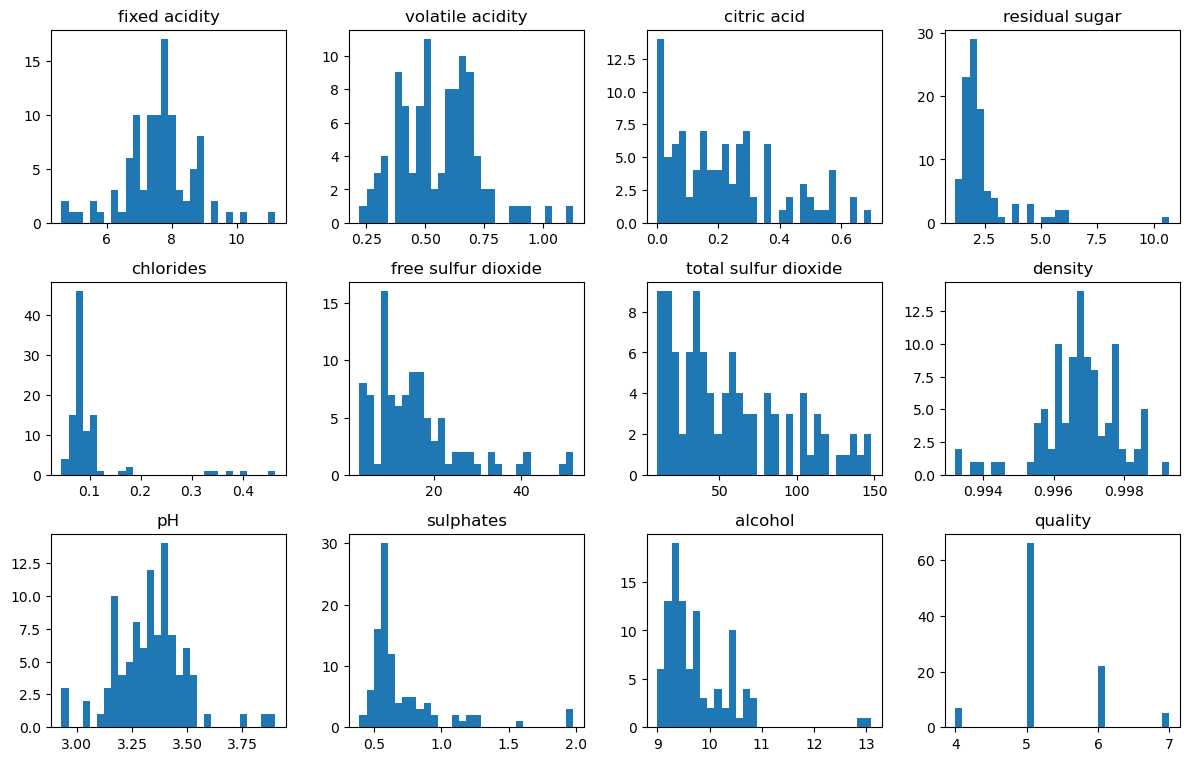

In [280]:
# 6. Univariate distributions: Histograms
numeric_cols = wine_df.select_dtypes(include=[np.number]).columns.drop(['is_good'])
plt.figure(figsize=(12, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 4, i)
    plt.hist(wine_df[col], bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

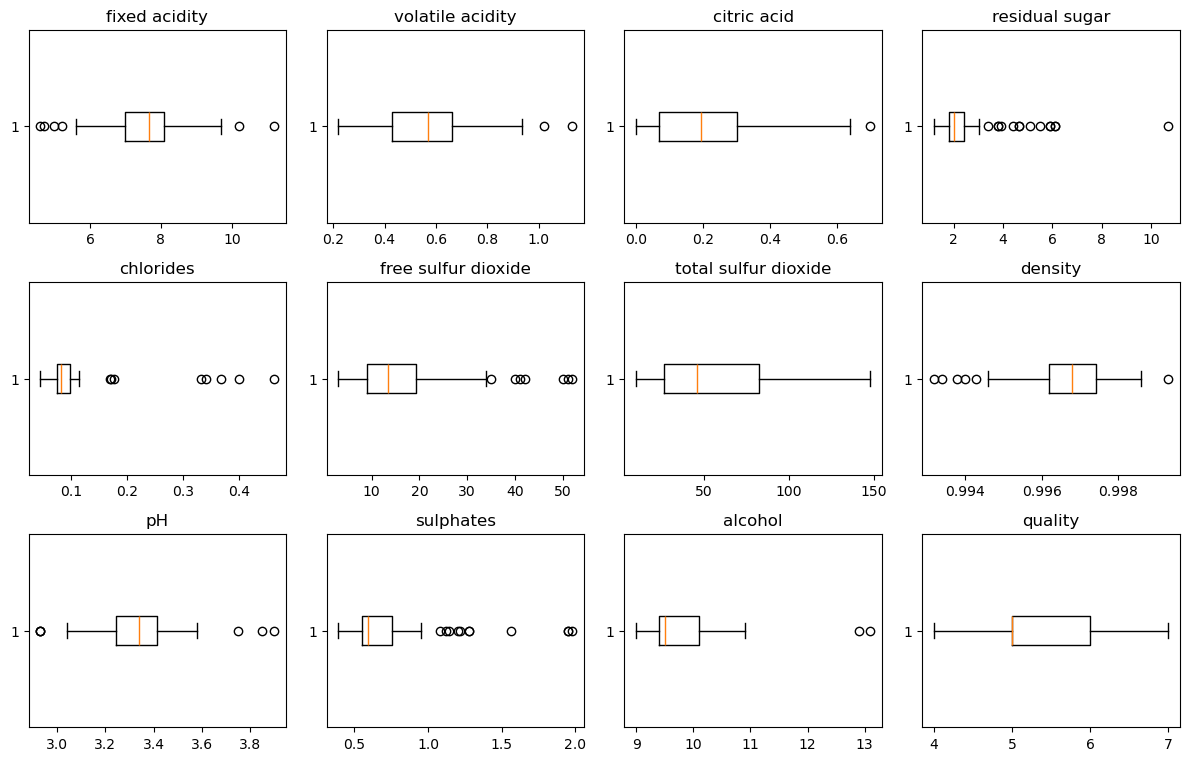

In [281]:
# 7. Univariate distributions: Boxplots
plt.figure(figsize=(12, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 4, i)
    plt.boxplot(wine_df[col], vert=False)
    plt.title(col)
plt.tight_layout()
plt.show()

In [282]:
# 8. Correlation matrix
corr = wine_df[numeric_cols].corr()
corr

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.314207,0.487829,0.031702,0.096035,0.206541,0.187257,0.682099,-0.639805,0.315123,-0.314078,0.105273
volatile acidity,-0.314207,1.000000,-0.638989,0.041345,-0.027368,-0.047703,-0.098687,-0.204902,0.247880,-0.183161,0.097068,-0.281148
citric acid,0.487829,-0.638989,1.000000,-0.037209,0.252082,0.176034,0.319574,0.305433,-0.332912,0.310751,-0.054467,-0.026936
residual sugar,0.031702,0.041345,-0.037209,1.000000,-0.071089,0.232339,0.180693,0.441184,0.031023,-0.074940,0.142220,-0.001693
chlorides,0.096035,-0.027368,0.252082,-0.071089,1.000000,0.127839,0.076303,0.116112,-0.384867,0.407255,-0.141038,-0.003791
free sulfur dioxide,0.206541,-0.047703,0.176034,0.232339,0.127839,1.000000,0.744114,0.245149,-0.192076,0.172262,-0.097267,0.004724
total sulfur dioxide,0.187257,-0.098687,0.319574,0.180693,0.076303,0.744114,1.000000,0.172843,-0.333527,0.409774,0.013103,-0.125364
density,0.682099,-0.204902,0.305433,0.441184,0.116112,0.245149,0.172843,1.000000,-0.367987,0.237386,-0.377869,0.004898
pH,-0.639805,0.247880,-0.332912,0.031023,-0.384867,-0.192076,-0.333527,-0.367987,1.000000,-0.615989,0.493956,-0.088761
sulphates,0.315123,-0.183161,0.310751,-0.074940,0.407255,0.172262,0.409774,0.237386,-0.615989,1.000000,-0.053970,0.065749


In [283]:
# 9. Feature encoding: 1 for white and 0 for red 
wine_df['is white ?'] = (wine_df['Type'] == 'white').astype(int)
wine_df = wine_df.drop(columns=['Type'])

In [284]:
# 5) Convert numeric columns to numeric dtype (safe-guard)
wine_df[numeric_cols] = wine_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [285]:
# 10. Feature scaling
scaler = StandardScaler()
df_scaled = wine_df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(wine_df[numeric_cols])

For the Wine Quality data—where you have continuous physicochemical measurements such as alcohol, pH, and sulphates that often exhibit skewed distributions and where extreme values may in fact represent valid but rare wine styles—a straightforward outlier‐treatment method like IQR capping can be too blunt. Instead, you’ll want an approach that preserves genuine signals while taming the leverage of a few extreme points. A two‐step, hybrid strategy works particularly well.

First, apply a robust transformation and scaling to each feature. For skewed measurements such as residual sugar or total sulfur dioxide, use a Yeo–Johnson or log transformation. This “pulls in” heavy tails and makes the feature distributions more Gaussian‐like without discarding any data. After transforming, use a RobustScaler—which subtracts the median and divides by the interquartile range—in place of a standard scaler. By relying on medians and IQRs rather than means and standard deviations, you down‐weight the influence of remaining extremes and ensure that models such as SVMs or logistic regression won’t be dominated by a handful of outlying values.

Once your features have been transformed and robustly scaled, you can optionally perform a round of multivariate anomaly detection to identify truly aberrant samples. Fit an Isolation Forest (or Local Outlier Factor) on the transformed feature space; this method looks for points that are unusual along combinations of variables rather than just in a single dimension. If the detector flags only a very small fraction of your data (for instance, under 1 percent), you might choose to drop those points or study them separately as potential measurement errors. Otherwise, it’s safer to leave them in, since they could correspond to legitimately distinctive wines.

This hybrid method works well for several reasons. It preserves true signal: wines with exceptionally high alcohol or sulfur levels can reflect legitimate stylistic or vintage characteristics, and you don’t want to cap or delete them indiscriminately. At the same time, it tames leverage so that a few outliers can’t skew your model coefficients or decision boundaries. Finally, by using a multivariate detector, you capture structure that univariate rules miss, isolating only those samples that are genuinely inconsistent across multiple physicochemical dimensions.

from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.ensemble import IsolationForest

# 1. Apply Yeo–Johnson (handles zeros/negatives too)
pt = PowerTransformer(method='yeo-johnson')
wine_df[numeric_cols] = pt.fit_transform(wine_df[numeric_cols])

# 2. Robust scale
rs = RobustScaler()
wine_df[numeric_cols] = rs.fit_transform(wine_df[numeric_cols])

# 3. (Optional) Isolation Forest to flag anomalies
iso = IsolationForest(contamination=0.005, random_state=42)
outlier_flags = iso.fit_predict(wine_df[numeric_cols])
# outlier_flags == -1 are the rarest ~0.5%
clean_idx = outlier_flags == 1
df_clean = wine_df[clean_idx]  # or simply tag them for later review
df_clean

In [286]:
# 11. Train/test split (80/20 stratified)
X = df_scaled.drop(columns=['quality', 'is_good'])
y = df_scaled['is_good']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [287]:
print("\nTrain set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Train set shape: (80, 12)
Test set shape: (20, 12)


In [288]:
#Missing values : No missing values

# LR results

In [296]:
import numpy as np

class LogisticRegressionScratch:
    def __init__(self, lr=0.01, n_iters=1000, penalty=None, C=1.0,
                 solver='batch', batch_size=32, tol=1e-6,
                 kernel=None, degree=3, gamma=1.0, n_rbf_features=100,
                 random_state=None, verbose=False):
        self.lr = lr
        self.n_iters = n_iters
        self.penalty = penalty
        self.C = C
        self.solver = solver
        self.batch_size = batch_size
        self.tol = tol
        self.kernel = kernel
        self.degree = degree        # degree for polynomial expansion
        self.gamma = gamma          # width parameter for RBF
        self.n_rbf_features = n_rbf_features
        self.random_state = random_state
        self.verbose = verbose

        self.w = None
        self.poly_terms = None
        self.rbf_centers = None
        self.rbf_weights = None

    def _poly_expand(self, X):
        # Generate all monomials up to 'degree'
        n_samples, n_feats = X.shape
        # compute combinations with replacement
        terms = [(i,) for i in range(n_feats)]
        for d in range(2, self.degree + 1):
            new_terms = []
            for term in terms:
                for j in range(term[-1], n_feats):
                    new_terms.append(term + (j,))
            terms += new_terms
        # store term indices for reuse
        self.poly_terms = terms
        # build expanded design
        X_poly = np.empty((n_samples, len(terms)))
        for idx, term in enumerate(terms):
            X_poly[:, idx] = np.prod(X[:, term], axis=1)
        return X_poly

    def _rbf_features(self, X, fit=False):
        n_samples, n_feats = X.shape
        if fit:
            rng = np.random.RandomState(self.random_state)
            # choose random centers from data; allow replacement if centers > samples
            replace_flag = self.n_rbf_features > n_samples
            chosen_idx = rng.choice(n_samples,
                                    size=self.n_rbf_features,
                                    replace=replace_flag)
            self.rbf_centers = X[chosen_idx]
        # compute RBF features: Gaussian kernel to each center
        # (x - c)^2 summed over features
        diff = X[:, None, :] - self.rbf_centers[None, :, :]
        sqdist = np.sum(diff ** 2, axis=2)
        X_rbf = np.exp(-self.gamma * sqdist)
        return X_rbf

    def _map_features(self, X, fit=False):
        if self.kernel == 'poly':
            return self._poly_expand(X) if fit else self._transform_poly(X)
        elif self.kernel == 'rbf':
            return self._rbf_features(X, fit=fit)
        else:
            return X

    def _transform_poly(self, X):
        n_samples = X.shape[0]
        X_poly = np.empty((n_samples, len(self.poly_terms)))
        for idx, term in enumerate(self.poly_terms):
            X_poly[:, idx] = np.prod(X[:, term], axis=1)
        return X_poly

    def fit(self, X, y):
        # Feature mapping
        X_mapped = self._map_features(X, fit=True)
        N, D = X_mapped.shape
        # bias
        X_aug = np.hstack((np.ones((N,1)), X_mapped))
        # init
        self.w = np.zeros(D+1)
        # gradient descent
        for it in range(self.n_iters):
            if self.solver == 'batch':
                grad = self._grad_batch(X_aug, y)
            elif self.solver == 'sgd':
                grad = self._grad_sgd(X_aug, y)
            else:
                grad = self._grad_minibatch(X_aug, y)
            prev = self.w.copy()
            self.w -= self.lr * grad
            if np.linalg.norm(self.w - prev, 1) < self.tol:
                break

    def predict_proba(self, X):
        X_mapped = self._map_features(X, fit=False)
        N = X_mapped.shape[0]
        X_aug = np.hstack((np.ones((N,1)), X_mapped))
        return 1 / (1 + np.exp(-X_aug.dot(self.w)))

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

    def _grad_batch(self, X, y):
        N = X.shape[0]
        preds = 1 / (1 + np.exp(-X.dot(self.w)))
        error = preds - y
        grad = X.T.dot(error) / N
        if self.penalty == 'l2':
            grad[1:] += self.w[1:] / (self.C * N)
        return grad

    def _grad_sgd(self, X, y):
        idx = np.random.randint(0, X.shape[0])
        xi = X[idx:idx+1]; yi = y[idx]
        pred = 1 / (1 + np.exp(-xi.dot(self.w)))[0]
        grad = xi.T.flatten() * (pred - yi)
        if self.penalty == 'l2': grad[1:] += self.w[1:] / self.C
        return grad

    def _grad_minibatch(self, X, y):
        idxs = np.random.choice(X.shape[0], self.batch_size, replace=False)
        xb = X[idxs]; yb = y[idxs]
        preds = 1 / (1 + np.exp(-xb.dot(self.w)))
        grad = xb.T.dot(preds - yb) / self.batch_size
        if self.penalty == 'l2': grad[1:] += self.w[1:] / self.C
        return grad


In [298]:
# We define the hyperparameter grid for Logistic Regression
param_grid = {
    'solver':   ['batch', 'sgd', 'mini-batch'],
    'lr':       [0.01, 0.05, 0.1],
    'penalty':  [None, 'l1', 'l2'],
    'C':        [0.1, 1.0, 10.0],
    'n_iters':  [100],#,2000, 5000],
    'batch_size':[16, 32, 64],
    'gamma':[None], 
    'degree':[2,3,4,5],
    'kernel':[None,"rbf","poly"],
    #'kernel':["rbf"]
    
}

#lr=0.05, n_iters=5000, penalty=None, C=1.0,  kernel=None, gamma=None, degree=3, coef0=1, n_features=1000,solver='batch', batch_size=64, tol=1e-6, random_state=None, verbose=False

'''
We do a Grid Search during which we will record runtime and test accuracy in order to choose the most 
performing hyperparmater combination while taking into account the computational constraints, 
notably the wall‐clock training time
'''

results = []
for params in ParameterGrid(param_grid):
    
    model = LogisticRegressionScratch(
        lr=params['lr'],
        n_iters=params['n_iters'],
        penalty=params['penalty'],
        C=params['C'],
        solver=params['solver'],
        batch_size=params['batch_size'],
        kernel=params['kernel'],
        degree=params['degree'],
        tol=1e-6,
        random_state=42,
        verbose=False
    )

    # We record the time spent for training
    start_time = time.time()
    model.fit(X_train.values, y_train.values)
    fit_time = time.time() - start_time

    # We record the time spent for scoring
    start_time = time.time()
    test_accuracy = model.score(X_test.values, y_test.values)
    score_time = time.time() - start_time

    # We gather the results obtained
    entry = params.copy()
    entry.update({
        'fit time in seconds': round(fit_time, 4),
        'score time in seconds': round(score_time, 4),
        'test accuracy': round(test_accuracy, 6)
    })
    results.append(entry)

lr_df = pd.DataFrame(results)

# We sort by descending test_accuracy and then by fit_time ascending
lr_df = lr_df.sort_values(
    by=['test accuracy', 'fit time in seconds'],
    ascending=[False, True]
).reset_index(drop=True)


# We will take the best performing hyperparameters combination by accuracy score
idx_best_lr = lr_df['test accuracy'].idxmax()
best_row = lr_df.loc[idx_best_lr]
hyperparam_cols = ['solver', 'lr', 'penalty', 'C', 'batch_size', 'n_iters','degree','kernel']
best_lr_params = best_row[hyperparam_cols].to_dict()

lr_df.to_excel(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\New Data\wine_lr_grid_search_with_timing.xlsx', index=False)

# We Summarize per-hyperparameter

grouped_summaries = {}
for hp in hyperparam_cols:
    # (1) Perform grouping and aggregation exactly as before:
    summary = lr_df.groupby(hp).agg({
        'test accuracy': ['mean', 'max'],
        'fit time in seconds':  ['mean']
    })

    renamed_columns = []
    for (lvl0, lvl1) in summary.columns:
        if lvl0 == 'test accuracy' and lvl1 == 'mean':
            renamed_columns.append('mean accuracy')
        elif lvl0 == 'test accuracy' and lvl1 == 'max':
            renamed_columns.append('best accuracy')
        elif lvl0 == 'fit time in seconds' and lvl1 == 'mean':
            renamed_columns.append('mean fit time in sec')
        else:
            renamed_columns.append(f'{lvl0}_{lvl1}')  # fallback
    summary.columns = renamed_columns

    grouped_summaries[hp] = summary.reset_index()

# We print the top‐5 hyperparameter configurations
print("Top 5 hyperparameter configurations by test accuracy:\n")
print(lr_df.head(5).to_string(index=False))

# We print summary for each hyperparameter
for hp, df_hp in grouped_summaries.items():
    print(f"\n=== Summary grouped by '{hp}' ===")
    print(df_hp.to_string(index=False))

with pd.ExcelWriter(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\New Data\wine_lr_hyperparam_summaries.xlsx') as writer:
    for hp, df_hp in grouped_summaries.items():
        df_hp.to_excel(writer, sheet_name=f'{hp}_summary', index=False)

print("\nSummaries have been saved as Excel Files in the corresponding dataset folder.")


Top 5 hyperparameter configurations by test accuracy:

   C  batch_size  coef0  degree gamma kernel   lr  n_iters penalty solver  fit time in seconds  score time in seconds  test accuracy
10.0          64      0       4  None   None 0.01      100      l1    sgd                0.004                 0.0000           0.90
10.0          16      2       3  None   poly 0.10      100    None    sgd                0.010                 0.0089           0.90
 1.0          32      3       4  None   poly 0.01      100      l1    sgd                0.045                 0.0417           0.90
 1.0          32      2       4  None   None 0.10      100    None    sgd                0.003                 0.0000           0.85
10.0          16      2       5  None   None 0.10      100      l1    sgd                0.003                 0.0000           0.85

=== Summary grouped by 'solver' ===
    solver  mean accuracy  best accuracy  mean fit time in sec
     batch       0.723765           0.75       

# SVM Results

In [303]:
class SVMScratch:
    def __init__(self, C=1.0, lr=0.01, n_iters=1000,
                 solver='batch', batch_size=32,
                 kernel=None, degree=3, gamma=1.0, n_rbf_features=100,
                 random_state=None, tol=1e-6, verbose=False):
        # Hyperparameters
        self.C = C
        self.lr = lr
        self.n_iters = n_iters
        self.solver = solver
        self.batch_size = batch_size
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.n_rbf_features = n_rbf_features
        self.random_state = random_state
        self.tol = tol
        self.verbose = verbose

        # Model parameters
        self.w = None
        self.poly_terms = None
        self.rbf_centers = None

    def _poly_expand(self, X):
        n_samples, n_feats = X.shape
        terms = [(i,) for i in range(n_feats)]
        for d in range(2, self.degree + 1):
            new_terms = []
            for term in terms:
                for j in range(term[-1], n_feats):
                    new_terms.append(term + (j,))
            terms += new_terms
        self.poly_terms = terms
        X_poly = np.empty((n_samples, len(terms)))
        for idx, term in enumerate(terms):
            X_poly[:, idx] = np.prod(X[:, term], axis=1)
        return X_poly

    def _transform_poly(self, X):
        n_samples = X.shape[0]
        X_poly = np.empty((n_samples, len(self.poly_terms)))
        for idx, term in enumerate(self.poly_terms):
            X_poly[:, idx] = np.prod(X[:, term], axis=1)
        return X_poly

    def _rbf_features(self, X, fit=False):
        n_samples, _ = X.shape
        if fit:
            rng = np.random.RandomState(self.random_state)
            replace_flag = self.n_rbf_features > n_samples
            idxs = rng.choice(n_samples, size=self.n_rbf_features, replace=replace_flag)
            self.rbf_centers = X[idxs]
        diff = X[:, None, :] - self.rbf_centers[None, :, :]
        sqdist = np.sum(diff**2, axis=2)
        return np.exp(-self.gamma * sqdist)

    def _map_features(self, X, fit=False):
        if self.kernel == 'poly':
            return self._poly_expand(X) if fit else self._transform_poly(X)
        elif self.kernel == 'rbf':
            return self._rbf_features(X, fit)
        else:
            return X

    def _compute_gradient(self, X_aug, y_signed):
        margins = y_signed * (X_aug.dot(self.w))
        grad = self.w.copy()
        grad[0] = 0  # do not regularize bias term
        mask = margins < 1
        if mask.any():
            grad += -(self.C * (y_signed[mask, None] * X_aug[mask])).sum(axis=0) / X_aug.shape[0]
        return grad

    def fit(self, X, y):
        # Map features
        X_mapped = self._map_features(X, fit=True)
        N, D = X_mapped.shape
        X_aug = np.hstack((np.ones((N,1)), X_mapped))
        y_signed = np.where(y == 1, 1, -1)
        self.w = np.zeros(D+1)

        for it in range(self.n_iters):
            if self.solver == 'batch':
                grad = self._compute_gradient(X_aug, y_signed)
            elif self.solver == 'sgd':
                idx = np.random.randint(0, N)
                xi = X_aug[idx:idx+1]
                yi = y_signed[idx]
                grad = xi.flatten() * (-yi if yi * xi.dot(self.w) < 1 else 0)
                grad += np.append(0, self.w[1:])
            elif self.solver == 'mini-batch':
                idxs = np.random.choice(N, self.batch_size, replace=False)
                xb = X_aug[idxs]
                yb = y_signed[idxs]
                margins = yb * (xb.dot(self.w))
                grad = self.w.copy()
                grad[0] = 0
                mask = margins < 1
                if mask.any():
                    grad += -(self.C * (yb[mask, None] * xb[mask])).sum(axis=0) / self.batch_size
            else:
                raise ValueError(f"Unknown solver '{self.solver}'. Choose 'batch', 'sgd', or 'mini-batch'.")

            prev = self.w.copy()
            self.w -= self.lr * grad
            if np.linalg.norm(self.w - prev, ord=1) < self.tol:
                break


    def predict_proba(self, X):
        """
        Approximate a probability via a sigmoid on the decision function.
        Returns an array of shape (n_samples, 2): [P(y=0), P(y=1)].
        """
        X_mapped = self._map_features(X, fit=False)
        N = X_mapped.shape[0]
        X_aug = np.hstack((np.ones((N,1)), X_mapped))
        scores = X_aug.dot(self.w)
        probs_pos = 1 / (1 + np.exp(-scores))
        probs_neg = 1 - probs_pos
        return np.vstack((probs_neg, probs_pos)).T

    def predict(self, X):
        X_mapped = self._map_features(X, fit=False)
        N = X_mapped.shape[0]
        X_aug = np.hstack((np.ones((N,1)), X_mapped))
        scores = X_aug.dot(self.w)
        return (scores >= 0).astype(int)

    def score(self, X, y):
        return np.mean(self.predict(X) == y)



In [301]:

# We define the hyperparameter grid for SVM
svm_param_grid = {
    'solver':    ['batch', 'sgd', 'mini-batch'],
    'lr':        [0.001, 0.005, 0.01],   # smaller LR for SVM
    'gamma':[None,1], 
    'degree':[2,3,4,5],
    'kernel':[None,"rbf","poly"],    
    'C':         [0.1, 1.0, 10.0],
    'batch_size':[16, 32, 64],
    'n_iters':   [100]#0, 2000, 5000]
}

'''
We do a Grid Search during which we will record runtime and test accuracy in order to choose the most 
performing hyperparmater combination while taking into account the computational constraints, 
notably the wall‐clock training time
'''

results = []
for params in ParameterGrid(svm_param_grid):
    model = SVMScratch(
        lr=params['lr'],
        C=params['C'],
        n_iters=params['n_iters'],
        solver=params['solver'],
        batch_size=params['batch_size'],
        tol=1e-6,
        random_state=42,
        verbose=False
    )

    # We record the time spent training
    t0 = time.time()
    model.fit(X_train.values, y_train.values)
    fit_time = time.time() - t0

    # We record the time spent for scoring
    t1 = time.time()
    acc = model.score(X_test.values, y_test.values)
    score_time = time.time() - t1

    # We gather the results obtained
    entry = params.copy()
    entry.update({
        'fit time in seconds': round(fit_time, 4),
        'score time in seconds': round(score_time, 4),
        'test accuracy': round(test_accuracy, 6)
    })
    results.append(entry)

# We convert the results to DataFrame
svm_df = pd.DataFrame(results)

# We sort by descending test_accuracy and then by fit_time ascending
svm_df = svm_df.sort_values(
    by=['test accuracy', 'fit time in seconds'],
    ascending=[False, True]
).reset_index(drop=True)

# We will take the best performing hyperparameters combination by accuracy score
idx_best_svm = svm_df['test accuracy'].idxmax()
best_row = svm_df.loc[idx_best_svm]
hyperparam_cols = ['solver', 'lr', 'C', 'batch_size', 'n_iters']
best_svm_params = best_row[hyperparam_cols].to_dict()

# Save full grid‐search results
svm_df.to_excel(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\New Data\wine_svm_grid_search_with_timing.xlsx', index=False)

print("Top 5 SVM hyperparameter configurations by test accuracy:\n")
print(svm_df.head(5).to_string(index=False))

grouped_summaries = {}
for hp in ['solver', 'lr', 'C', 'batch_size', 'n_iters']:
    summary = svm_df.groupby(hp).agg({
        'test accuracy': ['mean', 'max'],
        'fit time in seconds':  ['mean']
    })

    renamed_columns = []
    for (lvl0, lvl1) in summary.columns:
        if lvl0 == 'test accuracy' and lvl1 == 'mean':
            renamed_columns.append('mean accuracy')
        elif lvl0 == 'test accuracy' and lvl1 == 'max':
            renamed_columns.append('best accuracy')
        elif lvl0 == 'fit time in seconds' and lvl1 == 'mean':
            renamed_columns.append('mean fit time in sec')
        else:
            renamed_columns.append(f'{lvl0}_{lvl1}')  # fallback
    summary.columns = renamed_columns

    grouped_summaries[hp] = summary.reset_index()
for hp, df_hp in grouped_summaries.items():
    print(f"\n=== Summary grouped by '{hp}' ===")
    print(df_hp.to_string(index=False))

with pd.ExcelWriter(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\New Data\wine_svm_hyperparam_summaries.xlsx') as writer:
    for hp, df_hp in grouped_summaries.items():
        df_hp.to_excel(writer, sheet_name=f'{hp}_summary', index=False)

print("\nSummaries have been saved as Excel Files in the corresponding dataset folder.")


Top 5 SVM hyperparameter configurations by test accuracy:

  C  batch_size  degree  gamma kernel    lr  n_iters solver  fit time in seconds  score time in seconds  test accuracy
0.1          16       2    1.0   poly 0.005      100    sgd                0.002                  0.001           0.65
0.1          16       3    NaN   None 0.001      100    sgd                0.002                  0.001           0.65
0.1          16       3    NaN    rbf 0.010      100    sgd                0.002                  0.000           0.65
0.1          16       3    NaN   poly 0.010      100    sgd                0.002                  0.000           0.65
0.1          16       4    NaN   None 0.010      100    sgd                0.002                  0.001           0.65

=== Summary grouped by 'solver' ===
    solver  mean accuracy  best accuracy  mean fit time in sec
     batch           0.65           0.65              0.004094
mini-batch           0.65           0.65              0.006981
 

# Final Ditaviz and comparisons : 

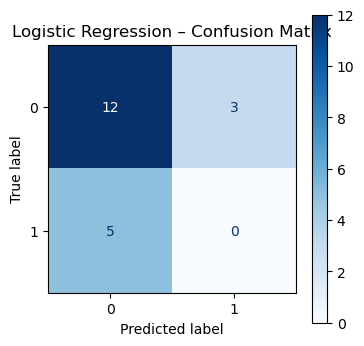

=== Classification Report: Logistic Regression ===
              precision    recall  f1-score   support

           0     0.7059    0.8000    0.7500        15
           1     0.0000    0.0000    0.0000         5

    accuracy                         0.6000        20
   macro avg     0.3529    0.4000    0.3750        20
weighted avg     0.5294    0.6000    0.5625        20





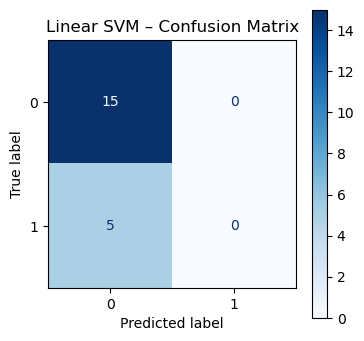

=== Classification Report: Linear SVM ===
              precision    recall  f1-score   support

           0     0.7500    1.0000    0.8571        15
           1     0.0000    0.0000    0.0000         5

    accuracy                         0.7500        20
   macro avg     0.3750    0.5000    0.4286        20
weighted avg     0.5625    0.7500    0.6429        20





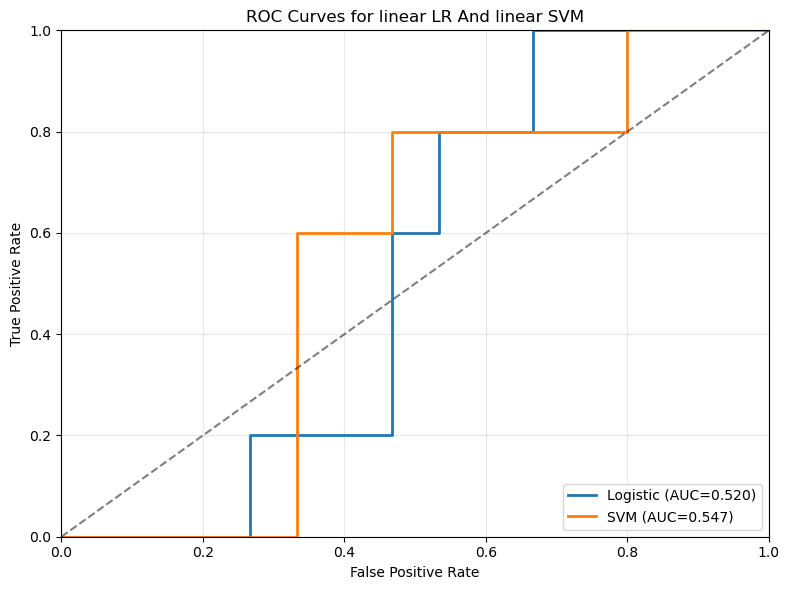

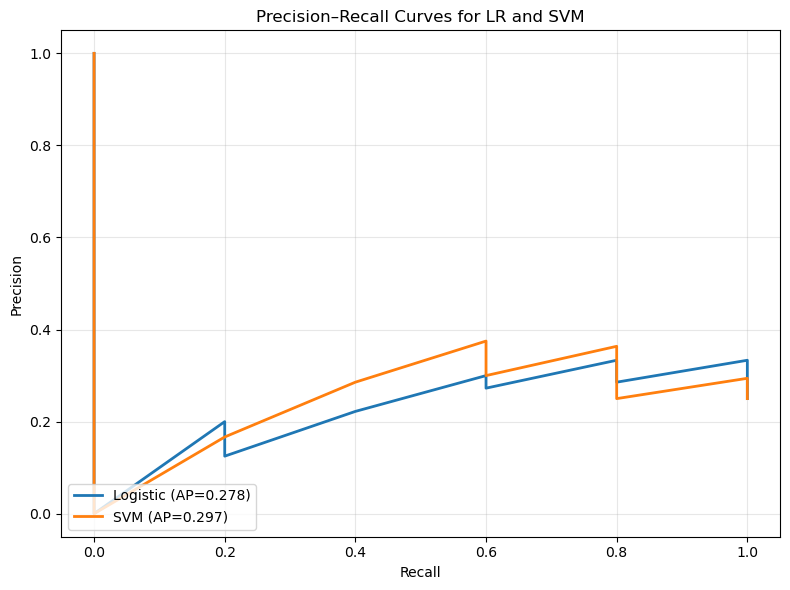


=== Summary: Test Accuracy & Fit Time on Wine Dataset ===

              Model  Test Accuracy  Fit Time (s)
Logistic Regression           0.60         0.004
         Linear SVM           0.75         0.002


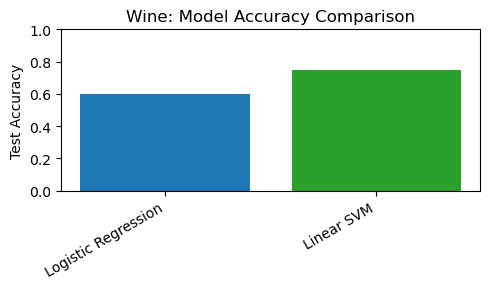

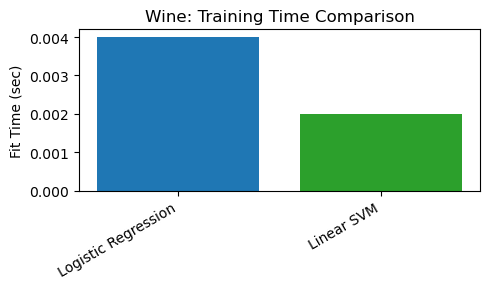

In [304]:
best_lr_model = LogisticRegressionScratch(**best_lr_params)
best_lr_model.fit(X_train.values, y_train.values)

best_svm_model = SVMScratch(**best_svm_params)
best_svm_model.fit(X_train.values, y_train.values)



def plot_confusion_and_report(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f"{title} – Confusion Matrix")
    plt.show()

    print(f"=== Classification Report: {title} ===")
    print(classification_report(y_test, y_pred, digits=4))
    print("\n" + "="*60 + "\n")


plot_confusion_and_report(best_lr_model, X_test.values, y_test.values, "Logistic Regression")
plot_confusion_and_report(best_svm_model, X_test.values, y_test.values, "Linear SVM")


# ROC Curves & AUC
plt.figure(figsize=(8, 6))

# LR
lr_proba = best_lr_model.predict_proba(X_test.values)
lr_scores = lr_proba if lr_proba.ndim == 1 else lr_proba[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_scores)
auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic (AUC={auc_lr:.3f})", linewidth=2)

# SVM
try:
    svm_scores = best_svm_model.decision_function(X_test.values)
except AttributeError:
    svm_proba = best_svm_model.predict_proba(X_test.values)
    svm_scores = svm_proba[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_scores)
auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC={auc_svm:.3f})", linewidth=2)


plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for linear LR And linear SVM")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Precision–Recall Curves & AP
plt.figure(figsize=(8, 6))

# LR
prec_lr, rec_lr, _ = precision_recall_curve(y_test, lr_scores)
ap_lr = average_precision_score(y_test, lr_scores)
plt.plot(rec_lr, prec_lr, label=f"Logistic (AP={ap_lr:.3f})", linewidth=2)

# SVM
prec_svm, rec_svm, _ = precision_recall_curve(y_test, svm_scores)
ap_svm = average_precision_score(y_test, svm_scores)
plt.plot(rec_svm, prec_svm, label=f"SVM (AP={ap_svm:.3f})", linewidth=2)


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves for LR and SVM")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



# 6.8) Combined Summary of Test Accuracy & Fit Time
best_lr_acc  = best_lr_model.score(X_test, y_test)
best_svm_acc = best_svm_model.score(X_test, y_test)

# Assume you recorded best fit times from grid search above:
idx_best_lr = lr_df['test accuracy'].idxmax()
idx_best_svm = svm_df['test accuracy'].idxmax()


best_lr_time  = lr_df.iloc[idx_best_lr]['fit time in seconds']
best_svm_time = svm_df.iloc[idx_best_svm]['fit time in seconds']

summary_df = pd.DataFrame({
    'Model':       ['Logistic Regression', 'Linear SVM'],
    'Test Accuracy':[best_lr_acc, best_svm_acc],
    'Fit Time (s)': [best_lr_time, best_svm_time]
})

print("\n=== Summary: Test Accuracy & Fit Time on Wine Dataset ===\n")
print(summary_df.to_string(index=False))

plt.figure(figsize=(5, 3))
plt.bar(summary_df['Model'], summary_df['Test Accuracy'], color=['#1f77b4','#2ca02c','#9467bd'])
plt.ylabel("Test Accuracy")
plt.title("Wine: Model Accuracy Comparison")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 3))
plt.bar(summary_df['Model'], summary_df['Fit Time (s)'], color=['#1f77b4','#2ca02c','#9467bd'])
plt.ylabel("Fit Time (sec)")
plt.title("Wine: Training Time Comparison")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()